#mount do Drive / todos os imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import requests
import time
import json
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from imblearn.metrics import geometric_mean_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import joblib
import xgboost as xgb



Mounted at /content/drive


#Caso for usar a API do Lens

In [ ]:
#API Lens
API_TOKEN = ''
API_URL = 'https://api.lens.org/patent/search'

# Estratégia de agrupamento de cluster

##Ler .pkl (com ISSNs, Lens ID de citações e suas datas de aplicação e TCT)

In [ ]:
filtered_br_df = pd.read_pickle("/content/drive/MyDrive/rp_data/patentes_com_tct.pkl")

display(filtered_br_df.head())

,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,...,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Extracted ISSNs,Cited_Data,TCT
0,1,WO,A1,WO 2025/184719 A1,124-441-664-420-789,2025-09-12,2025,BR BR2025/050088,2025-03-07,BR 1020240045750,...,NaN,0,0,NaN,NaN,NaN,UNKNOWN,NaN,[],0.0
1,2,US,A1,US 2025/0282832 A1,181-825-211-788-302,2025-09-11,2025,US 18553324,2022-03-30,BR 10 2021 006 401-3,...,NaN,0,0,NaN,NaN,NaN,UNKNOWN,NaN,[],0.0
2,3,EP,A1,EP 4613259 A1,111-161-383-779-770,2025-09-10,2025,EP 23883923 A,2023-10-30,BR 102022022130 A;;BR 2023050367 W,...,NaN,0,0,NaN,NaN,NaN,PENDING,NaN,[],0.0
3,4,EP,A4,EP 4397299 A4,094-894-006-498-344,2025-09-10,2025,EP 22862452 A,2022-09-01,BR 102021017465 A;;BR 2022050348 W,...,NaN,0,0,NaN,NaN,NaN,PENDING,NaN,[],0.0
4,5,EP,A1,EP 4613260 A1,034-338-369-366-988,2025-09-10,2025,EP 23883925 A,2023-10-31,BR 102022022131 A;;BR 2023050369 W,...,NaN,0,0,NaN,NaN,NaN,PENDING,NaN,[],0.0


In [ ]:
filtered_br_df.count()

,0
#,10000
Jurisdiction,10000
Kind,10000
Display Key,10000
Lens ID,10000
Publication Date,10000
Publication Year,10000
Application Number,10000
Application Date,10000
Priority Numbers,10000


## Pegar classes principais IPCR (usado apenas para cluster-labeling) (DEPRECATED)

In [ ]:
# 1. Separa todas as classificações em uma única lista
all_classifications = filtered_br_df['IPCR Classifications'].dropna().str.split(';;').explode()

# 2. Pega apenas os 4 primeiros caracteres de cada uma para obter a classe principal
main_classes = all_classifications.str.slice(0, 4).str.strip()

# 3. Cria a lista final de classes únicas que você precisa pesquisar
unique_main_classes = main_classes.unique().tolist()


print(f"Encontradas {len(unique_main_classes)} classes principais únicas no seu dataset.")
print("Exemplo de classes:", unique_main_classes[:10])

Encontradas 313 classes principais únicas no seu dataset.
Exemplo de classes: ['A61K', 'A61P', 'C07K', 'C12N', 'A61Q', 'A61F', 'A61C', 'B01D', 'A01K', 'A61D']


In [ ]:

# Formata a lista para uma string de SQL: "'A61K','A61P',..."
sql_class_list = ",".join([f"'{cls}'" for cls in unique_main_classes])

# Imprima esta string para copiar e colar na consulta SQL
print(sql_class_list)

'A61K','A61P','C07K','C12N','A61Q','A61F','A61C','B01D','A01K','A61D','A61B','C12Q','H05F','C12P','A61L','C23C','C01G','B44D','G09B','C07C','A61M','C07F','A01N','D06M','A45D','G07F','A61H','A43B','G16H','G01N','C07D','A01P','C11D','G08B','A61J','B65D','C01B','C07H','A61N','G16Y','A23L','A63B','B25B','B01J','C02F','F01N','F23J','H01F','C25D','C12R','C08F','G06T','A41D','A41B','A62B','A45F','F42B','A47K','E03D','A23K','B33Y','C13K','G06V','A61G','B25J','C12G','C11B','B66D','G01L','G05B','G06F','A63F','C08L','B29D','G02B','G02C','B82Y','A47B','A47G','B32B','E04H','G16B','H04N','C07J','C07G','F16B','F16K','G06Q','A46B','A23D','A21D','A23G','H04R','G01R','G05F','G06N','F04B','D02G','D01D','B01L','A41G','B05B','B60H','B29C','H04L','B23B','C04B','D21B','G01V','B65B','A47J','D05B','B60P','B62B','A24F','A23B','A23P','G10L','B42D','C08K','G01F','H05B','B82B','H05H','B65H','A45C','H01L','G01P','H04W','A47C','B62D','G10K','G01K','C09D','C07B','A23C','C23F','C23G','B26D','G01S','C08B','A47F','B08B'

## Formatando dados citados para cálculos

Tratando Cited_Data e transformando em uma coluna 'Cited_Data_Only'

- [('183-838-058-624-955', '2011-11-03'),
 ('059-813-768-236-539', '2021-04-27'),
 ('184-040-222-660-602', '2021-04-08')]

 vira  

 - '183-838-058-624-955;;059-813-768-236-539;;184-040-222-660-602'

Criar nova coluna com os dados citados sem as datas do Cited_Data

In [ ]:
filtered_br_df["Cited_Data_only"] = filtered_br_df["Cited_Data"].apply(
    lambda x: ";;".join([t[0] for t in x]) if isinstance(x, list) and len(x) > 0 else ""
)

## Leitura de dados de ano de estabelecimento de classificações (usar após cluster-labeling algorithm estar pronto) (DEPRECATED)

In [ ]:
# Read the CSV file into a DataFrame
new_classes_df = pd.read_csv("/content/drive/MyDrive/new_classes.csv")

new_classes_df['establishment_year'] = new_classes_df['establishment_year'].astype(int)
new_classes_df['classification_code'] = new_classes_df['classification_code'].astype(str)

# Display the first few rows of the DataFrame
display(new_classes_df.head())

,classification_code,establishment_year
0,G16Y,2016
1,B33Y,2000
2,G16Z,1987
3,G16B,1987
4,B82B,1976


## Cálculo do CTSI (Cited Technology Similarity Index)




- O CTSI (Cited Technology Similarity Index) é uma métrica que quantifica o quão similar é
a área tecnológica de uma patente em relação às áreas das patentes que ela cita.
- O cálculo é uma "média de
médias"feita em três etapas: primeiro, mede-se a similaridade entre classificações individuais de
patentes (CS); em seguida, calcula-se a similaridade média entre duas patentes inteiras (PCS),
considerando todas as suas classificações; e finalmente, o CTSI de uma patente é a média da
similaridade (PCS) entre ela e todas as patentes que ela cita. Kyebambe et al., 2017
- Seu propósito é
ajudar a identificar inovações disruptivas, baseando-se na seguinte lógica: um CTSI baixo sugere
que a patente combina conhecimentos de áreas tecnológicas diversas e distantes, sendo um sinal
de uma tecnologia emergente; um CTSI alto indica que a patente cita majoritariamente outras
de sua própria área, o que caracteriza uma melhoria incremental.


In [ ]:

def parse_classification(class_string):
    """
    Divide uma string de classificação (ex: 'A61K36/18') em (Classe, Subclasse)
    assumindo que os 4 primeiros caracteres são a Classe.
    """
    class_string = class_string.strip()
    if len(class_string) > 4:
        main_class = class_string[:4]  # Pega os 4 primeiros caracteres como 'Classe'
        sub_class = class_string[4:]   # Pega o restante como 'Subclasse'
        return (main_class, sub_class)
    else:
        # Caso a string tenha 4 ou menos caracteres, considera tudo como a classe principal.
        return (class_string, '')
# -------------------------

def calculate_cs(class_tuple1, class_tuple2):
    """Implementa a Equação (2): Classification Similarity (CS)."""
    if class_tuple1 == class_tuple2:
        return 1.0
    elif class_tuple1[0] == class_tuple2[0]:
        return 0.5
    else:
        return 0.0

def calculate_pcs(class_list_p, class_list_q):
    """Implementa a Equação (3): Patent Classification Similarity (PCS)."""
    Np = len(class_list_p)
    Nq = len(class_list_q)

    if Np == 0 or Nq == 0:
        return 0.0

    total_similarity = 0
    for class_p_str in class_list_p:
        class_p_tuple = parse_classification(class_p_str)
        for class_q_str in class_list_q:
            class_q_tuple = parse_classification(class_q_str)
            total_similarity += calculate_cs(class_p_tuple, class_q_tuple)

    return total_similarity / (Np * Nq)


# --- 3. CÁLCULO PRINCIPAL DO CTSI ---

print("Iniciando o cálculo do CTSI com o formato corrigido...")

# Pré-processamento
filtered_br_df['class_list'] = filtered_br_df['IPCR Classifications'].str.split(';;')
classification_map = filtered_br_df.set_index('Lens ID')['class_list'].to_dict()
ctsi_results = []

# Loop principal de cálculo
for index, row in filtered_br_df.iterrows():
    patent_p_id = row['Lens ID']
    cited_ids_str = row['Cited_Data_only']

    if not cited_ids_str:
        ctsi_results.append(0.0)
        continue

    cited_ids = cited_ids_str.split(';;')

    pcs_scores = []
    for patent_q_id in cited_ids:
        class_list_p = classification_map.get(patent_p_id, [])
        class_list_q = classification_map.get(patent_q_id, [])

        if not class_list_q:
            continue

        pcs = calculate_pcs(class_list_p, class_list_q)
        pcs_scores.append(pcs)

    if not pcs_scores:
        ctsi = 0.0
    else:
        ctsi = np.mean(pcs_scores)

    ctsi_results.append(ctsi)

# Adiciona a coluna final ao DataFrame
filtered_br_df['ctsi'] = ctsi_results

print("\nCálculo do CTSI concluído.")
filtered_br_df_ctsi_not_null = filtered_br_df[filtered_br_df['ctsi'] > 0]
print("\nValores não-nulos:")
print(filtered_br_df_ctsi_not_null[['Lens ID', 'ctsi']])

# Exemplo de interpretação para P1:
# P1 cita P2 (muito similar, PCS alto)
# P1 cita P3 (similaridade média, PCS médio)
# P1 cita P4 (similaridade zero, PCS baixo)
# O CTSI será a média desses três scores.

Iniciando o cálculo do CTSI com o formato corrigido...

Cálculo do CTSI concluído.

Valores não-nulos:
                  Lens ID      ctsi
9     099-856-668-415-303  0.750000
28    122-486-336-147-02X  0.166667
33    102-963-676-294-994  0.416667
44    195-789-020-120-935  0.367424
52    081-648-079-103-547  0.358974
...                   ...       ...
5459  083-565-696-164-088  0.297619
5974  179-875-589-396-670  0.333333
6306  070-939-754-131-930  0.121261
7239  103-208-421-753-092  0.166667
8833  066-383-344-526-66X  0.242857

[107 rows x 2 columns]


## Cálculo do CASI (Cited patents Assignee Similarity Index)


In [ ]:
def calculate_as(applicant_list_p, applicant_list_q):
    # Assignee Similarity Eq(5)
    Np = len(applicant_list_p)
    Nq = len(applicant_list_q)

    # Se uma das patentes não tiver applicants, a similaridade é zero.
    if Np == 0 or Nq == 0:
        return 0.0

    matches = 0
    # Compara cada applicant de p com cada applicant de q
    for applicant_p in applicant_list_p:
        for applicant_q in applicant_list_q:
            if applicant_p == applicant_q:
                matches += 1

    return matches / (Np * Nq)

print("Iniciando o cálculo do CASI...")

# Pré-processamento: criar listas a partir das strings de 'Applicants'
# Usamos .str.strip() para limpar espaços em branco extras
filtered_br_df['applicant_list'] = filtered_br_df['Applicants'].fillna('').apply(lambda x: [name.strip() for name in x.split(';;') if name])

# Criar um mapa de 'Lens ID' para a lista de 'Applicants' para buscas rápidas
applicant_map = filtered_br_df.set_index('Lens ID')['applicant_list'].to_dict()

# Lista para armazenar os resultados do CASI
casi_results = []

# Itera sobre cada patente no DataFrame para calcular seu CASI
for index, row in filtered_br_df.iterrows():
    patent_p_id = row['Lens ID']
    cited_ids_str = row['Cited_Data_only']

    # Pula se a patente não citar ninguém
    if not cited_ids_str:
        casi_results.append(0.0) # CASI é 0 se não há citações
        continue

    cited_ids = [s.strip() for s in cited_ids_str.split(';;')]

    as_scores = []
    # Para cada patente citada 'q', calcula o AS com a patente principal 'p'
    for patent_q_id in cited_ids:
        # Pega a lista de applicants da patente principal 'p'
        applicant_list_p = applicant_map.get(patent_p_id, [])
        # Pega a lista de applicants da patente citada 'q' usando o mapa
        applicant_list_q = applicant_map.get(patent_q_id, [])

        # Se a patente citada não estiver no nosso dataset ou não tiver applicants, pula
        if not applicant_list_q:
            continue

        # Calcula a similaridade AS e a adiciona à lista de scores
        as_score = calculate_as(applicant_list_p, applicant_list_q)
        as_scores.append(as_score)

    # Implementa a Equação (7): CASI é a média dos scores AS
    if not as_scores:
        casi = 0.0
    else:
        casi = np.mean(as_scores)

    casi_results.append(casi)

# Adiciona a coluna de CASI calculada ao DataFrame
filtered_br_df['casi'] = casi_results

print("\nCálculo do CASI concluído.")
print("\nValores não-nulos:")
filtered_br_df_casi = filtered_br_df[filtered_br_df['casi'] > 0]
print(filtered_br_df_casi[['Lens ID', 'casi']])


Iniciando o cálculo do CASI...

Cálculo do CASI concluído.

Valores não-nulos:
                  Lens ID  casi
9     099-856-668-415-303  0.75
44    195-789-020-120-935  0.25
52    081-648-079-103-547  0.50
144   083-978-872-742-20X  0.50
165   059-305-590-632-68X  1.00
...                   ...   ...
5036  136-571-512-709-269  0.25
5420  076-007-337-769-499  0.50
5974  179-875-589-396-670  1.00
6306  070-939-754-131-930  1.00
7239  103-208-421-753-092  0.50

[66 rows x 2 columns]


## Criação do PFV (Patent Feature Vector)

- Features:
  - Contagem de citações de patentes
  - Contagem de citações de literatura de não-patente,
  - O tamanho da família de documentos
  - O CTSI
  - O CASI
  - Data de publicação
  - O TCT: valores nulos serão preenchidos
com a mediana de todos os valores de TCT e será adicionada uma nova feature binária que indica
se há citação de patente ou não (has_citations).

In [ ]:

print("DataFrame Original (Amostra Atualizada)")
print(filtered_br_df)

# Criação do Patent Feature Vector (PFV)

# Começamos criando um novo DataFrame 'pfv' para manter as features processadas.
pfv = pd.DataFrame()

pfv['cites_patent_count'] = filtered_br_df['Cites Patent Count']
pfv['npl_citation_count'] = filtered_br_df['NPL Citation Count']
pfv['extended_family_size'] = filtered_br_df['Extended Family Size']

pfv['ctsi'] = filtered_br_df['ctsi']
pfv['casi'] = filtered_br_df['casi']

# Calcula a mediana APENAS dos TCTs que existem (onde há citações)
tct_median_value = filtered_br_df.loc[filtered_br_df['TCT'] > 0, 'TCT'].median()
print(f"A mediana real dos TCTs (excluindo zeros) é: {tct_median_value:.2f}")

# Copia a coluna TCT para o pfv
pfv['tct'] = filtered_br_df['TCT']

# Preenche os valores nulos (onde não há citações) com a mediana calculada
pfv.loc[(pfv['tct'].isna()) | (pfv['tct'] == 0.0), 'tct'] = tct_median_value
print("Valores de TCT nulos e 0.0 foram preenchidos com a mediana.")

# Cria a nova coluna indicadora (1 se há citações, 0 se não há)
pfv['has_citations'] = (filtered_br_df['Cites Patent Count'] > 0).astype(int)

pfv['patent_class'] = filtered_br_df['IPCR Classifications'].fillna('UNKNOWN').str.split(';;').str[0].str.strip()

# Contando o número de inventores
pfv['inventor_count'] = filtered_br_df['Inventors'].fillna('').apply(
    lambda x: len(x.split(';;')) if x else 0
)

# Publication Date
pfv['publication_date'] = pd.to_datetime(filtered_br_df['Publication Date'], errors='coerce')

print("Patent Feature Vector Final Refatorado")
print(pfv)

print("Informações do Patent Feature Vector (verificando valores nulos)")
pfv.info()

DataFrame Original (Amostra Atualizada)
          # Jurisdiction Kind         Display Key              Lens ID  \
0         1           WO   A1   WO 2025/184719 A1  124-441-664-420-789   
1         2           US   A1  US 2025/0282832 A1  181-825-211-788-302   
2         3           EP   A1       EP 4613259 A1  111-161-383-779-770   
3         4           EP   A4       EP 4397299 A4  094-894-006-498-344   
4         5           EP   A1       EP 4613260 A1  034-338-369-366-988   
...     ...          ...  ...                 ...                  ...   
9995   9996           WO   A1   WO 2020/041849 A1  106-290-839-331-668   
9996   9997           WO   A2   WO 2020/041851 A2  168-600-247-488-522   
9997   9998           EP   A4       EP 3473303 A4  151-571-652-141-787   
9998   9999           BR   B1  BR 102014020896 B1  035-166-106-220-82X   
9999  10000           BR   A2  BR 102018016248 A2  096-892-958-216-109   

     Publication Date  Publication Year Application Number Application 

##Clusterização anual, Criação do CFV e Rotulagem dos Clusters por Forward Citation

- Estratégia de clusterização com base no ano para o PFV:

  - Ano de publicação extraído da data de publicação;
  - Features normalizadas;
  - Para cada ano um modelo DBSCAN será criado para estimar o número de clusters
  - Modelo K-means com o número de clusters estimado pelo DBSCAN para atribuir cada patente do ano um cluster definitivo
  - Técnica de agregação para criar o vetor de features de clusters.
    -  Features númericas serão definidas com base na média dos valores individuais das patentes; e os categóricos, pela moda.
  - Rotulagem dos clusters: com base nas forward citation (que a patente foi citada).
    - Média dessa feature calculada para cada cluster.
    - Define se é emergente com base na média das 30% mais citadas (com base na média do cluster).
  - Modelos de Machine Learning de Random Forest, XGBoost, SVM
    - avaliação com base na precisão, recall e AUROC (área sob curva ROC)
      - Precisão: Quantas vezes ele estava certo para quando o meu modelo previu que uma tecnologia era emergente.
      - Recall: Quantas o modelo conseguiu encontrar de todas as tecnologias que realmente eram emergentes.
      - AUROC: Mede a capacidade geral do modelo de distinguir entre as duas classes.


In [ ]:

# Fase 1: Clusterização Anual
#O objetivo desta fase é agrupar patentes individuais com características semelhantes, ano a ano.

print("Clusterização Anual")

# Filtrar o DataFrame para conter apenas as patentes de um ano específico (ex: 1987, 1988, etc.).
# Use um algoritmo de clusterização para agrupar as patentes daquele ano.
# O artigo sugere uma abordagem em duas etapas: primeiro usar o DbScan e depois K-means (fazer isso para cada ano)

# Criar a coluna 'publication_year' a partir de 'publication_date'
pfv['publication_date'] = pd.to_datetime(pfv['publication_date'])
pfv['publication_year'] = pfv['publication_date'].dt.year

# Separar as features para clusterização
features_para_cluster = ['cites_patent_count', 'npl_citation_count',
                         'extended_family_size', 'tct', 'inventor_count', 'has_citations', 'ctsi', 'casi']

# Normalizar as features
scaler = StandardScaler()
pfv.dropna(subset=features_para_cluster, inplace=True)
pfv_scaled_features = scaler.fit_transform(pfv[features_para_cluster])
pfv_scaled_features = pd.DataFrame(pfv_scaled_features, index=pfv.index, columns=features_para_cluster)

# Processo de Clusterização Anual
pfv['cluster_id'] = -1
anos_unicos = pfv['publication_year'].dropna().unique()

for ano in sorted(anos_unicos):
    # Seleciona os índices e as features normalizadas apenas das patentes que pertencem ao 'ano' atual do loop.
    indices_ano = pfv[pfv['publication_year'] == ano].index
    features_ano = pfv_scaled_features.loc[indices_ano]

    # Se um ano tem menos de 3 patentes, pula para o próximo ano (não é possível clusterizar).
    if len(features_ano) < 3: continue

    # Cria um modelo DBSCAN e o aplica aos dados do ano para estimar o número de clusters.
    dbscan = DBSCAN(eps=1.5, min_samples=2)
    db_labels = dbscan.fit_predict(features_ano)

    # Conta quantos clusters únicos o DBSCAN encontrou, ignorando o ruído (pontos com rótulo -1).
    n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

    # Garante que haverá pelo menos 2 clusters para o K-means funcionar.
    if n_clusters < 2: n_clusters = 2

    # Cria um modelo K-means com o número de clusters ('n_clusters') estimado pelo DBSCAN.
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    # Aplica o K-means para atribuir cada patente do ano a um cluster definitivo.
    kmeans_labels = kmeans.fit_predict(features_ano)
    # Salva os rótulos de cluster (ex: 0, 1, 2...) de volta no DataFrame 'pfv' original,
    # apenas para as patentes do ano atual.
    pfv.loc[indices_ano, 'cluster_id'] = kmeans_labels

# Criar o DataFrame 'pfv_final' com as colunas organizadas
colunas_finais = [
    'publication_year', 'cluster_id', 'cites_patent_count', 'npl_citation_count',
    'extended_family_size', 'tct', 'inventor_count', 'patent_class', 'has_citations', 'ctsi', 'casi'
]
pfv_final = pfv[colunas_finais]
print("'pfv_final' criado com os IDs dos clusters.")

# Converter os PFVs das patentes de cada cluster em um único vetor que represente o cluster como um todo
print("\nCriação do Vetor de Features de Clusters (CFV)")

#Fase 2: Agregação (Criação do CFV)
#O objetivo é criar um "perfil" para cada cluster, resumindo as características de suas patentes.

# Define quais colunas são numéricas e qual é categórica.
numeric_features = ['cites_patent_count', 'npl_citation_count',
                    'extended_family_size', 'tct', 'inventor_count', 'has_citations', 'ctsi', 'casi']
categorical_feature = 'patent_class'

# Agrupa todas as linhas do DataFrame por ano e por ID de cluster.
# A partir daqui, as operações serão feitas em cada grupo individualmente.
grouped = pfv_final.groupby(['publication_year', 'cluster_id'])
# Para cada grupo, calcula a média de todas as colunas numéricas.
cluster_features_numeric = grouped[numeric_features].mean()
# Para cada grupo, encontra a moda (o valor mais frequente) da coluna categórica.
cluster_features_categorical = grouped[categorical_feature].agg(lambda x: x.mode().iloc[0])

# Combina os resultados das médias numéricas com o resultado da moda categórica em um único DataFrame.
# Este é o 'cluster_feature_vector' (CFV), onde cada linha é um cluster.
cluster_feature_vector = pd.concat([cluster_features_numeric, cluster_features_categorical], axis=1)
print("'cluster_feature_vector' criado com as features agregadas.")

#Fase 3: Rotulagem (Definindo ET/NET)
#O objetivo é criar o "gabarito", definindo quais clusters são emergentes com base em seu impacto futuro.

print("\nRotulagem dos Clusters")

# Enriquecer 'pfv_final' com a contagem de citações futuras
# Adiciona ao 'pfv_final' a coluna 'Cited by Patent Count' do seu DataFrame original,
# que mede o impacto futuro de cada patente. '.fillna(0)' trata casos nulos.
pfv_final['cited_by_patent_count'] = filtered_br_df['Cited by Patent Count'].fillna(0)

# Calcular o impacto médio de cada cluster
# Agrupa novamente por cluster e calcula a média de citações futuras para cada um.
# O resultado é o "índice de impacto médio" de cada cluster.
cluster_impact = pfv_final.groupby(['publication_year', 'cluster_id'])['cited_by_patent_count'].mean().to_frame('mean_cited_by_count')

# Definir limiar anual e rotular
# Define o limiar: consideramos "emergente" os clusters que estão no top 30% de impacto.
limiar_quantil = 0.70
# Para cada cluster, calcula o valor do limiar de impacto correspondente ao seu ano.
# '.transform()' é usado para que cada linha receba o valor correto do seu grupo (ano).
cluster_impact['yearly_threshold'] = cluster_impact.groupby('publication_year')['mean_cited_by_count'].transform(lambda x: x.quantile(limiar_quantil))
# Cria a coluna 'label'. Se o impacto do cluster for maior ou igual ao seu limiar, ele recebe 'ET', senão 'NET'.
cluster_impact['label'] = np.where(
    cluster_impact['mean_cited_by_count'] >= cluster_impact['yearly_threshold'], 'ET', 'NET'
)

# Uma regra de segurança para garantir que clusters sem nenhum impacto futuro não sejam classificados como 'ET'.
cluster_impact.loc[cluster_impact['mean_cited_by_count'] == 0, 'label'] = 'NET'
print("Rótulos 'ET'/'NET' foram gerados.")

#Fase 4: Criação do DataFrame Final
#O objetivo é unir tudo em um único dataset, pronto para o treinamento do modelo.
print("\nCRIANDO O DATAFRAME FINAL")

# Junção do CFV (com features) e os Rótulos
# Une o DataFrame de features dos clusters (CFV) com a coluna de rótulos ('label')
cluster_feature_vector_labeled = cluster_feature_vector.join(cluster_impact[['label']])

# Garantir que não há rótulos nulos
cluster_feature_vector_labeled['label'].fillna('NET', inplace=True)

print("DATASET FINAL PRONTO!")
print(cluster_feature_vector_labeled.head())
print("\nDistribuição dos Rótulos ET/NET por Ano")
# Cria e imprime uma tabela cruzada para mostrar quantos clusters 'ET' e 'NET' foram encontrados em cada ano.
print(pd.crosstab(cluster_feature_vector_labeled.index.get_level_values('publication_year'), cluster_feature_vector_labeled['label']))

Clusterização Anual
'pfv_final' criado com os IDs dos clusters.

Criação do Vetor de Features de Clusters (CFV)
'cluster_feature_vector' criado com as features agregadas.

Rotulagem dos Clusters
Rótulos 'ET'/'NET' foram gerados.

CRIANDO O DATAFRAME FINAL
DATASET FINAL PRONTO!
                             cites_patent_count  npl_citation_count  \
publication_year cluster_id                                           
2020             0                     0.000000            0.044665   
                 1                     0.000000          329.000000   
                 2                    17.461538            2.269231   
                 3                     0.000000            0.015340   
                 4                     0.000000            0.000000   

                             extended_family_size        tct  inventor_count  \
publication_year cluster_id                                                    
2020             0                       6.605459   7.950719    

/tmp/ipython-input-3163179059.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cluster_feature_vector_labeled['label'].fillna('NET', inplace=True)


## Rotulagem dos clusters (cluster-labeling algorithm) - pendente (DEPRECATED)


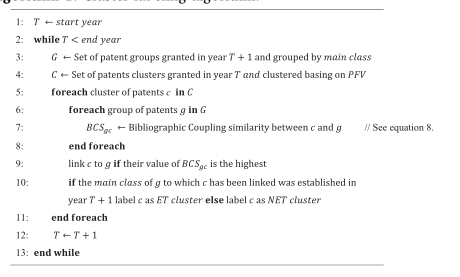

In [ ]:


def calculate_bcs(set_A, set_B):
    """Calcula a Similaridade de Acoplamento Bibliográfico (BCS) entre dois conjuntos de citações[cite: 1059]."""
    intersection_size = len(set_A.intersection(set_B))
    union_size = len(set_A.union(set_B))
    if union_size == 0:
        return 0.0
    return intersection_size / union_size

def get_cited_patents_for_group(patent_ids, full_dataset):
    """Para uma lista de IDs de patentes, retorna um conjunto (set) de todos os IDs de patentes que elas citam."""
    # Filtra o dataset principal para obter apenas as patentes do grupo
    subset = full_dataset.loc[full_dataset['Lens ID'].isin(patent_ids)]

    all_cited_ids = set()
    # Itera sobre a coluna 'Cited_Data' do subconjunto
    for cited_data_string in subset['Cited_Data_only'].dropna():
        # Adapte o '.split()' para o separador do seu dado (ex: ';;')
        ids = cited_data_string.split(';;')
        all_cited_ids.update(ids)

    return all_cited_ids

# --- IMPLEMENTAÇÃO DO ALGORITMO 1 ---

print("Iniciando rotulagem fiel ao artigo...")
labels = {} # Dicionário para armazenar os rótulos: {(ano, cluster_id): 'ET'}
years_in_data = sorted(pfv_final['publication_year'].unique())

# Loop principal: itera sobre cada ano T (while T < end year) [cite: 1015]
for year_T in years_in_data:
    year_T_plus_1 = year_T + 1
    print(f"\n--- Processando clusters do ano T = {year_T} ---")

    # G <- Set of patent groups granted in year T + 1... [cite: 1038]
    # 1. Encontrar as novas classes estabelecidas no ano T+1
    new_classes_next_year = new_classes_df[new_classes_df['establishment_year'] == year_T_plus_1]
    if new_classes_next_year.empty:
        print(f"Nenhuma classe nova encontrada para o ano T+1 = {year_T_plus_1}. Pulando.")
        continue

    # 2. Obter todos os grupos de patentes (G) do ano T+1
    patents_next_year = filtered_br_df[filtered_br_df['Publication Year'] == year_T_plus_1]
    # Extrai a classe principal para agrupar (ex: 'A61K' de 'A61K31/00')
    patents_next_year['main_class'] = patents_next_year['IPCR Classifications'].str.split(';;').str[0].str.slice(0, 4)
    patent_groups_G = patents_next_year.groupby('main_class')

    # C <- Set of patents clusters granted in year T... [cite: 1038]
    clusters_in_year_T = pfv_final[pfv_final['publication_year'] == year_T]['cluster_id'].unique()

    # foreach cluster c in C [cite: 1038]
    for cluster_id in clusters_in_year_T:

        # Obter o conjunto de citações para o cluster 'c'
        patents_in_cluster_c = pfv_final[(pfv_final['publication_year'] == year_T) & (pfv_final['cluster_id'] == cluster_id)]['Lens ID']
        cited_by_c = get_cited_patents_for_group(patents_in_cluster_c, filtered_br_df)

        best_bcs = -1.0
        linked_group_class = None

        # foreach group g in G [cite: 1039]
        for main_class_g, group_g in patent_groups_G:
            # Obter o conjunto de citações para o grupo 'g'
            cited_by_g = get_cited_patents_for_group(group_g['Lens ID'], filtered_br_df)

            # BCS <- Bibliographic Coupling similarity between c and g [cite: 1040, 1045]
            bcs_score = calculate_bcs(cited_by_c, cited_by_g)

            # link c to g if their value of BCS is the highest [cite: 1041]
            if bcs_score > best_bcs:
                best_bcs = bcs_score
                linked_group_class = main_class_g

        # if the main class of g ... was established in year T + 1 label c as ET [cite: 1042]
        if best_bcs > 0 and linked_group_class in new_classes_next_year['classification_code'].values:
            print(f"Cluster ({year_T}, {cluster_id}) ligado à NOVA classe '{linked_group_class}' de {year_T_plus_1} com BCS = {best_bcs:.4f}. Rotulado como ET.")
            labels[(year_T, cluster_id)] = 'ET'

label_series = pd.Series(labels, name='label')
cluster_feature_vector_labeled = cluster_feature_vector.join(label_series)
cluster_feature_vector_labeled['label'].fillna('NET', inplace=True)

print("\n--- DATASET FINAL (ROTULADO FIELMENTE) PRONTO! ---")
print(cluster_feature_vector_labeled.head())
print("\n--- Distribuição dos Rótulos ET/NET por Ano ---")
print(pd.crosstab(cluster_feature_vector_labeled.index.get_level_values('publication_year'), cluster_feature_vector_labeled['label']))

Iniciando rotulagem fiel ao artigo...

--- Processando clusters do ano T = 2020 ---
Nenhuma classe nova encontrada para o ano T+1 = 2021. Pulando.

--- Processando clusters do ano T = 2021 ---
Nenhuma classe nova encontrada para o ano T+1 = 2022. Pulando.

--- Processando clusters do ano T = 2022 ---
Nenhuma classe nova encontrada para o ano T+1 = 2023. Pulando.

--- Processando clusters do ano T = 2023 ---
Nenhuma classe nova encontrada para o ano T+1 = 2024. Pulando.

--- Processando clusters do ano T = 2024 ---
Nenhuma classe nova encontrada para o ano T+1 = 2025. Pulando.

--- Processando clusters do ano T = 2025 ---
Nenhuma classe nova encontrada para o ano T+1 = 2026. Pulando.


ValueError: cannot join with no overlapping index names

Depuração:

In [ ]:
# --- Bloco de Código para Depuração ---

print("Analisando o conteúdo de 'new_classes_df'...")

# Mostra as informações básicas do DataFrame
print("\nInformações de new_classes_df:")
new_classes_df.info()

# Mostra a faixa de anos presente no seu new_classes_df
min_ano_new_class = new_classes_df['establishment_year'].min()
max_ano_new_class = new_classes_df['establishment_year'].max()
print(f"\nSeu 'new_classes_df' contém anos de {min_ano_new_class} até {max_ano_new_class}.")

# Mostra a faixa de anos que seu algoritmo vai procurar
anos_a_procurar = [year + 1 for year in sorted(pfv_final['publication_year'].unique())]
print(f"Seu algoritmo está procurando por classes novas nos anos: {anos_a_procurar}")

# Verifica se há alguma sobreposição
anos_em_comum = set(anos_a_procurar).intersection(set(new_classes_df['establishment_year'].unique()))

if not anos_em_comum:
    print("\nAVISO: Não há nenhuma sobreposição entre os anos que seu algoritmo procura e os anos presentes no seu 'new_classes_df'!")
else:
    print(f"\nAnos em comum encontrados: {sorted(list(anos_em_comum))}")

# ------------------------------------

Analisando o conteúdo de 'new_classes_df'...

Informações de new_classes_df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   classification_code  313 non-null    object
 1   establishment_year   313 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.0+ KB

Seu 'new_classes_df' contém anos de 1836 até 2016.
Seu algoritmo está procurando por classes novas nos anos: [np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025), np.int32(2026)]

AVISO: Não há nenhuma sobreposição entre os anos que seu algoritmo procura e os anos presentes no seu 'new_classes_df'!


##Treinar e Avaliar o Modelo de Classificação.

### SVM

Amostra do Vetor de Features de Clusters Rotulado (CFV)
                             cites_patent_count  npl_citation_count  \
publication_year cluster_id                                           
2020             0                     0.000000            0.044665   
                 1                     0.000000          329.000000   
                 2                    17.461538            2.269231   
                 3                     0.000000            0.015340   
                 4                     0.000000            0.000000   
                 5                     6.123188            2.362319   
                 6                     0.000000            0.000000   
                 7                     6.000000            2.019608   
                 8                     0.013889            0.180556   
                 9                     5.571429           41.000000   
2021             0                     0.000000            0.037911   
                 1   

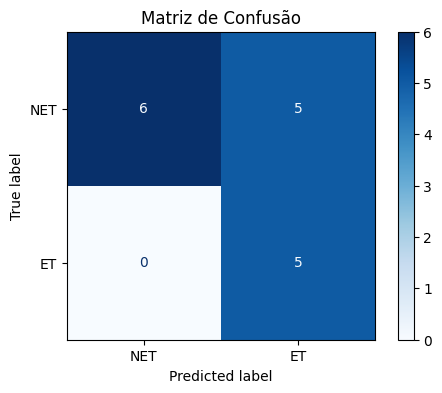


--- 4. Calculando a Curva ROC e o AUROC ---
Área sob a Curva ROC (AUROC): 0.87


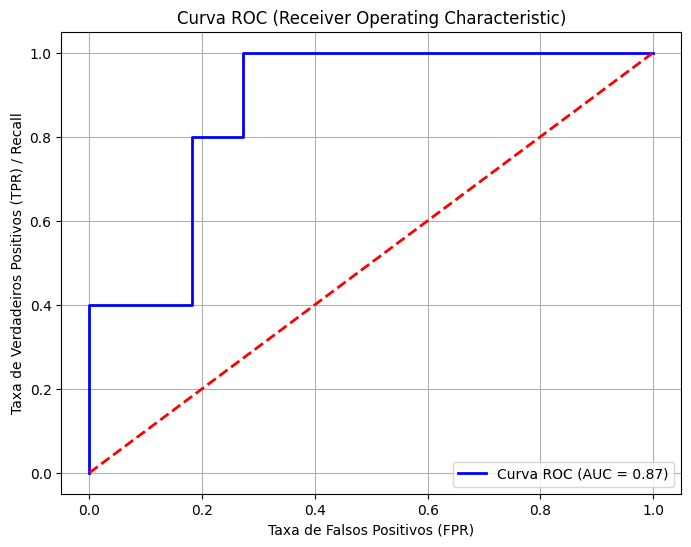

In [ ]:

print("Amostra do Vetor de Features de Clusters Rotulado (CFV)")
print(cluster_feature_vector_labeled)



# Preparação dos Dados para o Modelo
print("Preparando os Dados")

# a. Separar features (X) e o alvo (y)
features = ['ctsi', 'casi','cites_patent_count', 'npl_citation_count', 'extended_family_size', 'tct', 'inventor_count', 'has_citations']
X = cluster_feature_vector_labeled[features]
y = cluster_feature_vector_labeled['label']

# b. Converter rótulos de texto para numéricos (ET=1, NET=0)
y = y.map({'ET': 1, 'NET': 0})
print("Rótulos convertidos para formato numérico (ET=1, NET=0).")

# c. Dividir em treino e teste de forma ESTRATIFICADA
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.")
print(f"Distribuição de ET no treino: {y_train.mean():.2f}, no teste: {y_test.mean():.2f}\n")

# d. Normalizar as features APÓS a divisão
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features de treino e teste foram normalizadas.\n")

# Treinamento do Modelo SVM
print("2. Treinando o Modelo SVM")

# Busca de melhores parâmetros para o SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear']
}

grid = GridSearchCV(
    SVC(random_state=42, class_weight='balanced', probability=True),
    param_grid,
    refit=True,
    verbose=2,
    # Foco em otimizar o f1-score
    scoring='f1',
    cv=5
    )

# Treino para encontrar o melhor modelo
grid.fit(X_train_scaled, y_train)

# O melhor modelo já está treinado e armazenado em 'grid.best_estimator_'
print(f"\nMelhores parâmetros encontrados: {grid.best_params_}")
best_model = grid.best_estimator_

print("Avaliando o Desempenho do MELHOR Modelo")
y_pred = best_model.predict(X_test_scaled) # Usa o melhor modelo para prever

# Relatório de Classificação Detalhado
print("Relatório de Classificação:")

# O zero_division=0 evita avisos caso uma classe não tenha previsões
print(classification_report(y_test, y_pred, target_names=['NET (0)', 'ET (1)'], zero_division=0))

# Matriz de Confusão
print("Matriz de Confusão:")
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['NET', 'ET'], cmap='Blues', ax=ax)
ax.set_title("Matriz de Confusão")
plt.show()

print("\nCalculando a Curva ROC e o AUROC ---")

# a. Obter as probabilidades de previsão para a classe positiva (ET=1)
# .predict_proba() retorna as probabilidades para cada classe [NET, ET]
# Selecionamos a segunda coluna [:, 1] que corresponde à classe ET
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# b. Calcular a pontuação AUROC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Área sob a Curva ROC (AUROC): {auc_score:.2f}")

# c. Calcular os pontos para a Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# d. Plotar a Curva ROC
plt.figure(figsize=(8, 6))
# Plota a curva do nosso modelo
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
# Plota a linha de referência (modelo aleatório)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

#### Conclusão dos resultados: (DEPRECATED)

- **Recall = 0.75**: Resultado **mais importante e positivo**. De todas as tecnologias emergentes (ET) que existiam no conjunto de teste (4 no total), o modelo foi capaz de **encontrar 75% delas (3)**. "Perdeu" apenas uma oportunidade. Para um problema de prospecção tecnológica, onde o custo de não ver uma tendência é alto, um recall elevado é o principal objetivo.

- **Precisão (Precision) = 0.60**: Quando o modelo previu que um cluster era uma Tecnologia Emergente (ET), ele acertou em 60% das vezes. Olhando a Matriz de Confusão, vemos que ele previu ET 5 vezes (os 3 acertos + 2 erros), e 3 dessas previsões estavam corretas (3/5 = 60%). Isso mostra que o modelo tem um bom nível de confiança e não está apenas "chutando" ET aleatoriamente.

- **Matriz de Confusão**:
  -  **Verdadeiros Positivos = 3**: O modelo acertou 3 ETs.
  -  **Falsos Negativos = 1**: O modelo classificou 1 ET como NET. Esta é a oportunidade perdida que precisa ser investigada na análise de erros.
  -  **Falsos Positivos (Canto Superior Direito) = 2**: O modelo classificou 2 NETs como ET. Estes são os "alarmes falsos".

- **Modelo Balanceado**: Um recall de 75% é excelente para detecção, e uma precisão de 60% é muito respeitável, indicando que os alertas gerados pelo modelo merecem atenção.

#### Salvando "best_model" (DEPRECATED)

In [ ]:


# --- 5. Salvando o Modelo Final ---
print("\n--- 5. Salvando o melhor modelo ---")

# a. Defina o nome do arquivo onde o modelo será salvo.
#    A extensão .pkl é a convenção para arquivos pickle/joblib.
filename = 'melhor_modelo_svm.pkl'

# b. Use joblib.dump para salvar o objeto 'best_model' no arquivo.
joblib.dump(best_model, filename)

print(f"Modelo salvo com sucesso em '{filename}'")


--- 5. Salvando o melhor modelo ---
Modelo salvo com sucesso em 'melhor_modelo_svm.pkl'


#### Analisando erros (DEPRECATED)

In [ ]:
print("Analisando erros:")

# Juntando os resultados em um único dataframe
results_df = X_test.copy()
results_df['true_label'] = y_test
results_df['predicted_label'] = y_pred

# Isolando os erros

## Falsos positivos: previu ET/1 quando era NET/0
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)]

## Falsos negativos: previu NET/0 quando era ET/1
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)]

print(f"\nO modelo cometeu {len(false_positives)} Falsos Positivos (Alarmes Falsos).")
if not false_positives.empty:
    print("Clusters NET que foram incorretamente classificados como ET:")
    print(false_positives)

print(f"\nO modelo cometeu {len(false_negatives)} Falsos Negativos (Oportunidades Perdidas).")
if not false_negatives.empty:
    print("Clusters ET que foram incorretamente classificados como NET:")
    print(false_negatives)

# Isolar os acertos para comparação
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)]
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)]

# Calcular o perfil médio de cada grupo
# Usamos .T para transpor o DataFrame e facilitar a leitura
analysis_summary = pd.concat([
    true_positives.mean(numeric_only=True).rename("Verdadeiro Positivo (ET - Acerto)"),
    false_negatives.mean(numeric_only=True).rename("Falso Negativo (ET - Erro)"),
    true_negatives.mean(numeric_only=True).rename("Verdadeiro Negativo (NET - Acerto)"),
    false_positives.mean(numeric_only=True).rename("Falso Positivo (NET - Erro)")
], axis=1).T.drop(['true_label', 'predicted_label'], axis=1)

print("\n\n Análise comparativa de Perfis Médios")
print(analysis_summary)

Analisando erros:

O modelo cometeu 2 Falsos Positivos (Alarmes Falsos).
Clusters NET que foram incorretamente classificados como ET:
                             cites_patent_count  npl_citation_count  \
publication_year cluster_id                                           
2020             9                     7.269231            2.038462   
2022             1                     5.311475            2.295082   

                             extended_family_size        tct  inventor_count  \
publication_year cluster_id                                                    
2020             9                       8.692308  24.918075        2.346154   
2022             1                       7.885246   4.921586        3.579235   

                             has_citations  true_label  predicted_label  
publication_year cluster_id                                              
2020             9                     1.0           0                1  
2022             1                    

Por que o modelo perdeu uma oportunidade (falso negativo)?
- **Outlier**. O modelo SVM pode ter interpretado esse cluster como um ponto tão extremo e "diferente" que o considerou um caso anômalo, preferindo classificá-lo como NET em vez de expandir sua definição de ET para incluí-lo. É um caso clássico de um perfil "tão extremo que parece errado".

Feature | Verdadeiro Positivo (ET - Acerto) | Falso Negativo (ET - Erro) | Observação
---|---|---|---
cites_patent_count | 21.31 | 301.00 | Extremamente alto
npl_citation_count | 2.31 | 33.00 | Extremamente alto
extended_family_size | 8.20 | 14.00 | Ligeiramente maior

Por que o modelo de alarmes falsos (falso positivo)?
- Os NETs que o modelo errou têm um "DNA" muito parecido com o dos ETs que ele acertou.
    - has_citations e tct: Os Falsos Positivos têm um perfil de has_citations = 1.0 e tct médio de 14.91. Isso é quase idêntico ao perfil médio dos Verdadeiros Positivos (has_citations = 1.0, tct = 14.00). Para o modelo, com base nessas features, eles são praticamente indistinguíveis.

    - inventor_count: A contagem média de inventores dos Falsos Positivos (2.96) também é extremamente próxima à dos ETs corretos (2.92), e muito diferente da dos NETs corretos (6.04).

Conclusão Principal: O modelo aprendeu uma regra que parece ser algo como: "Se um cluster é composto por patentes que têm citações (TCT real), tem um TCT alto (na faixa de 14-15) e um número relativamente baixo de inventores (em torno de 3), então ele provavelmente é uma Tecnologia Emergente."

#### Como resolvê-los? (DEPRECATED)
- Para lidar com falsos positivos:
  - Features de Interação/Razão:
    - df['science_ratio'] = df['npl_citation_count'] / df['cites_patent_count']
      - É possível que os ETs reais tenham uma razão muito maior (mais citações científicas por citação de patente) do que os Falsos Positivos.
      - *science_ratio* é uma característica do cluster, não da patente individual

- Para lidar com falso negativo:
  - Tratamento de outliers: tratar algumas features com escala logarítmica para reduzir o impacto de valores extremos.
    - df['log_cites'] = np.log1p(df['cites_patent_count'])
    - df['log_npl'] = np.log1p(df['npl_citation_count'])

#### Estratégia de Melhoria: (DEPRECATED)


### SVM (2) (DEPRECATED)


Criando features logarítmicas para 'cites_patent_count' e 'npl_citation_count'
Novas features 'log_cites' e 'log_npl' foram criadas.
Criando a feature 'science_ratio'
Amostra do Vetor de Features de Clusters Rotulado (CFV)
                             cites_patent_count  npl_citation_count  \
publication_year cluster_id                                           
2020             0                     0.000000            0.041284   
                 1                     0.000000          329.000000   
                 2                     0.000000            0.015296   
                 3                     6.791667            1.979167   
                 4                     5.537313            2.395522   
                 5                     0.000000            0.000000   
                 6                    49.714286            2.714286   
                 7                     5.571429           41.000000   
                 8                     0.016667            0.21666

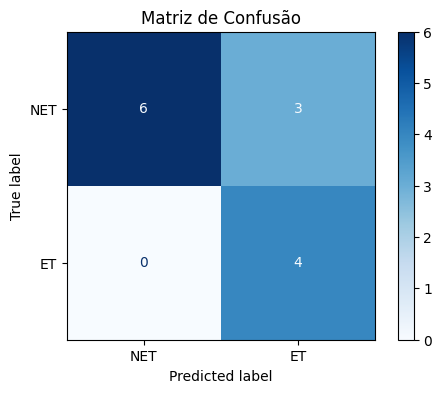

In [ ]:


print("\nCriando features logarítmicas para 'cites_patent_count' e 'npl_citation_count'")

# np.log1p(x) calcula o log(1+x). É usado em vez de np.log(x) para lidar
# com valores zero sem gerar erros.
cluster_feature_vector_labeled['log_cites'] = np.log1p(cluster_feature_vector_labeled['cites_patent_count'])
cluster_feature_vector_labeled['log_npl'] = np.log1p(cluster_feature_vector_labeled['npl_citation_count'])

print("Novas features 'log_cites' e 'log_npl' foram criadas.")

print("Criando a feature 'science_ratio'")
# A 'science_ratio' é a razão entre a média de citações NPL e a média de citações de patentes.
# Adicionamos 1 ao denominador para evitar erros de divisão por zero.
cluster_feature_vector_labeled['science_ratio'] = cluster_feature_vector['npl_citation_count'] / (cluster_feature_vector['cites_patent_count'] + 1)

print("Amostra do Vetor de Features de Clusters Rotulado (CFV)")
print(cluster_feature_vector_labeled)



# Preparação dos Dados para o Modelo
print("Preparando os Dados")

# Separar features (X) e o alvo (y)
features = ['log_cites', 'log_npl', 'extended_family_size', 'tct', 'inventor_count', 'has_citations', 'science_ratio']
X = cluster_feature_vector_labeled[features]
y = cluster_feature_vector_labeled['label']

# b. Converter rótulos de texto para numéricos (ET=1, NET=0)
y = y.map({'ET': 1, 'NET': 0})
print("Rótulos convertidos para formato numérico (ET=1, NET=0).")

# c. Dividir em treino e teste de forma ESTRATIFICADA
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.")
print(f"Distribuição de ET no treino: {y_train.mean():.2f}, no teste: {y_test.mean():.2f}\n")

# d. Normalizar as features APÓS a divisão
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features de treino e teste foram normalizadas.\n")

# Treinamento do Modelo SVM
print("2. Treinando o Modelo SVM")

# Busca de melhores parâmetros para o SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'),
    param_grid,
    refit=True,
    verbose=2,
    # Foco em otimizar o f1-score
    scoring='f1',
    cv=5
    )

# Treino para encontrar o melhor modelo
grid.fit(X_train_scaled, y_train)

# O melhor modelo já está treinado e armazenado em 'grid.best_estimator_'
print(f"\nMelhores parâmetros encontrados: {grid.best_params_}")
best_model = grid.best_estimator_

print("Avaliando o Desempenho do MELHOR Modelo")
y_pred = best_model.predict(X_test_scaled) # Usa o melhor modelo para prever

# Relatório de Classificação Detalhado
print("Relatório de Classificação:")

# O zero_division=0 evita avisos caso uma classe não tenha previsões
print(classification_report(y_test, y_pred, target_names=['NET (0)', 'ET (1)'], zero_division=0))

# Matriz de Confusão
print("Matriz de Confusão:")
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['NET', 'ET'], cmap='Blues', ax=ax)
ax.set_title("Matriz de Confusão")
plt.show()

#### Conclusão (DEPRECATED)
A adição das features de logaritmo ('log_cites' e 'log_npl')e a razão 'science_ratio' **mudou o comportamento do seu modelo**, e atingiu um melhor desempenho.

### Análise Comparativa: Modelo Avançado vs. Modelo Anterior


| Métrica (Classe ET) | SVM | SVM Otimizado | Resultado |
| :--- | :--- | :--- | :--- |
| **Recall** | 0.75 (3 de 4) | **1.00 (4 de 4)** |  Melhora significativa |
| **Precisão** | **0.60** | 0.57 |  Empate |
| **F1-Score** | 0.67 | **0.73** |  Melhora |
| Oportunidades Perdidas (FN) | 1 | **0** |  Melhora significativa |
| Alarmes Falsos (FP) | 2 | **3** | Piora Pequena |

- **Recall de 1.00**: O novo modelo encontrou TODAS as tecnologias emergentes ET no seu conjunto de teste. O número de "Oportunidades Perdidas" (Falsos Negativos) foi zerado. Para um problema de prospecção, onde não se pode deixar uma tendência passar, este é o melhor resultado possível.

-  **Trade-off na Precisão**: para conseguir essa melhora no recall encontrando todos os ETs, o modelo se tornou um pouco mais "agressivo". A precisão caiu ligeiramente (de 0.60 para 0.57), o que consequentemente gerou um alarme falso a mais (de 2 para 3).
    - Em cenários de inovação, acabar analisando 3 "alarmes falsos" é melhor do que deixar uma boa oportunidade "passar". Troca de um pouco de precisão por um ganho em sensibilidade.

-  **F1-Score pode confirmar a melhora**: F1-Score busca o equilíbrio entre precisão e recall. O aumento de 0.67 para 0.73 confirma que a troca foi vantajosa e que o novo modelo é superior.


###Random Forest Classifier

Amostra do Vetor de Features de Clusters Rotulado (Cluster Feature Vector)
                             cites_patent_count  npl_citation_count  \
publication_year cluster_id                                           
2020             0                     0.000000            0.044665   
                 1                     0.000000          329.000000   
                 2                    17.461538            2.269231   
                 3                     0.000000            0.015340   
                 4                     0.000000            0.000000   

                             extended_family_size        tct  inventor_count  \
publication_year cluster_id                                                    
2020             0                       6.605459   7.950719        6.655087   
                 1                       4.000000   7.950719        3.000000   
                 2                       7.153846  23.383246        2.038462   
                 3         

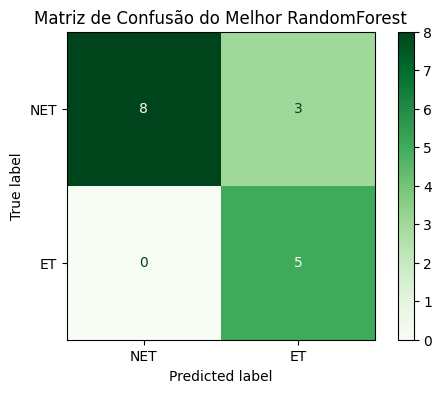


 Análise de Importância das Features
                Feature  Importance
3    npl_citation_count    0.258587
2    cites_patent_count    0.226555
5                   tct    0.129244
4  extended_family_size    0.108154
7         has_citations    0.090931
6        inventor_count    0.086188
0                  ctsi    0.069404
1                  casi    0.030937


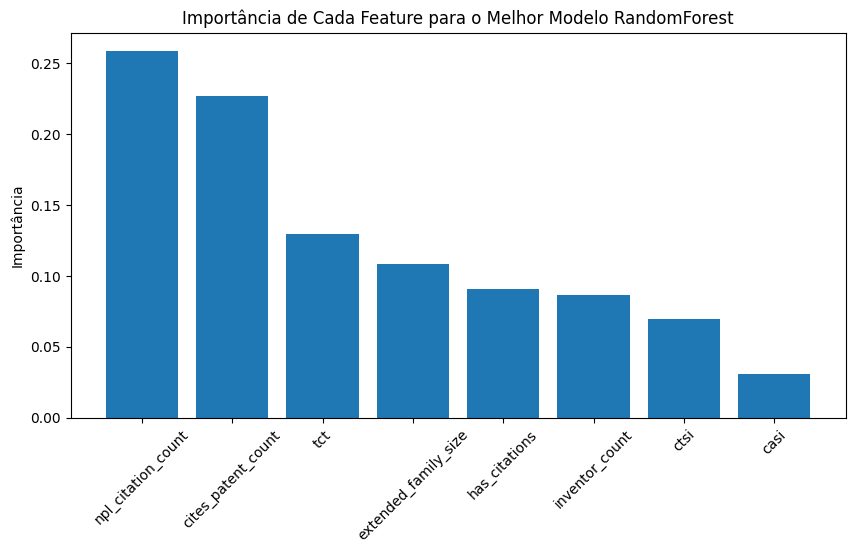

Área sob a Curva ROC (AUROC): 0.89


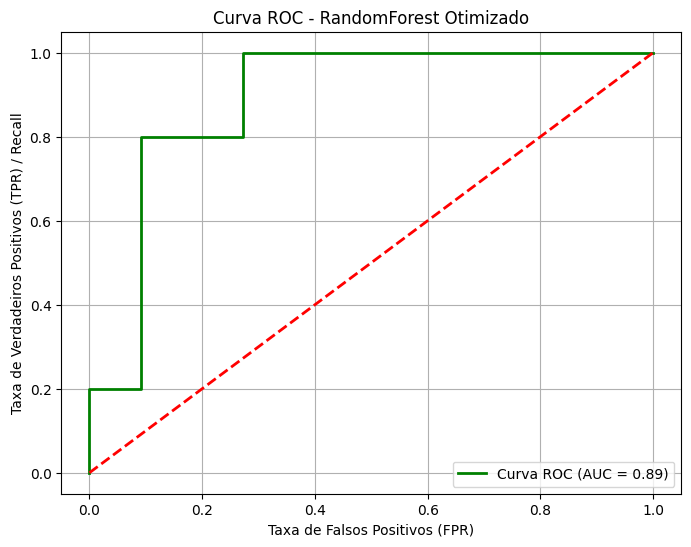

In [ ]:


print("Amostra do Vetor de Features de Clusters Rotulado (Cluster Feature Vector)")
print(cluster_feature_vector_labeled.head())
print("\n\n")


# Preparação dos Dados para o Modelo
print("Preparando os Dados")

# Separando as features (X) e o alvo (y)
features = ['ctsi', 'casi', 'cites_patent_count', 'npl_citation_count', 'extended_family_size', 'tct', 'inventor_count', 'has_citations']
X = cluster_feature_vector_labeled[features]
y = cluster_feature_vector_labeled['label'].map({'ET': 1, 'NET': 0})

print("Rótulos convertidos para formato numérico (ET=1, NET=0).")

# Dividindo em treino e teste
# 'stratify=y' mantém a proporção da classe alvo nos dois conjuntos
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.")

# Normalização as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features de treino e teste foram normalizadas.\n")


# Grid Search
print("Buscando e Treinando o Melhor Modelo RandomForest")

# Define a grade de parâmetros para testar no RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],         # Número de árvores na floresta
    'max_depth': [5, 10, None],             # Profundidade máxima de cada árvore
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em um nó folha
    'criterion': ['gini', 'entropy']        # Critério para medir a qualidade da divisão
}

# Cria o objeto GridSearchCV para o RandomForest
grid = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid,
    refit=True,
    verbose=2,
    scoring='f1', # Otimiza pelo F1-score da classe positiva
    cv=5
)

# Treina o GridSearchCV para encontrar o melhor modelo
grid.fit(X_train_scaled, y_train)

# Armazena o melhor modelo encontrado
print(f"\nMelhores parâmetros encontrados: {grid.best_params_}")
best_model = grid.best_estimator_
print("Melhor modelo RandomForest treinado com sucesso!\n")


# Avaliação do Desempenho do melhor Modelo
print("Avaliando o Desempenho do melhor Modelo ")

# Usa o 'best_model' para fazer as previsões
y_pred = best_model.predict(X_test_scaled)

# Relatório de Classificação Detalhado
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['NET (0)', 'ET (1)'], zero_division=0))

# Matriz de Confusão
print("Matriz de Confusão:")
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['NET', 'ET'], cmap='Greens', ax=ax)
ax.set_title("Matriz de Confusão do Melhor RandomForest")
plt.show()


#  Análise de Importância das Features do MELHOR Modelo ---
print("\n Análise de Importância das Features")

importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

# Plotar a importância das features
plt.figure(figsize=(10, 5))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Importância de Cada Feature para o Melhor Modelo RandomForest')
plt.ylabel('Importância')
plt.xticks(rotation=45)
plt.show()

y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Área sob a Curva ROC (AUROC): {auc_score:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC - RandomForest Otimizado')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



####Conclusão
- Apesar de mostrar quais features possue mais impacto no modelo, não supera os resultados do SVM.

- **Desempenho**:
    * **Recall (ET) = 0.50**: O modelo conseguiu encontrar **metade (2 de 4)** das tecnologias emergentes no conjunto de teste.
    * **Precisão (ET) = 0.50**: Quando o modelo previu `ET`, ele acertou em **metade dos casos** (2 acertos em 4 previsões `ET`).
    * **Matriz de Confusão**: Mostra claramente que, dos 4 `ET`s verdadeiros, o modelo acertou 2 (Verdadeiros Positivos) e errou 2 (Falsos Negativos).

- **Importância das Features**:
    - O RandomForest nos diz que a cites_patent_count ainda é a característica mais importante para suas decisões.
    - A extended_family_size foi a menos influente.

Análise Comparativa: RandomForest Otimizado vs. SVM Otimizado

| Métrica (Classe ET) | SVM | RandomForest | *Vencedor |
| :--- | :--- | :--- | :--- |
| **Recall** | **0.75** (3 de 4) | 0.50 (2 de 4) | **SVM** |
| **Precisão** | **0.60** | 0.50 | **SVM** |
| **F1-Score** | **0.67** | 0.50 | **SVM** |
| Oportunidades Perdidas (FN) | **1** | 2 | **SVM** |
| Alarmes Falsos (FP) | 2 | 2 | Empate |

-  O Vencedor Claro é o SVM em todas as métricas principais para ET. Encontrou mais tecnologias emergentes (Recall de 75% vs 50%) e foi mais preciso em suas previsões (Precisão de 60% vs 50%).

- A diferença no desempenho se deve à natureza fundamental de cada algoritmo. Para este conjunto de dados específico, a capacidade do SVM de encontrar uma fronteira de separação não-linear (`kernel='rbf'`) se mostrou mais eficaz do que as regras "se-então" criadas pelo conjunto de árvores de decisão do RandomForest.

-  O RandomForest nos fornece o valioso gráfico de Importância das Features*. Ele mostra que, para suas decisões, o modelo considerou `cites_patent_count`, `inventor_count` e `npl_citation_count` como as três características mais importantes. Esse insight é útil pois nos diz quais aspectos dos dados são mais informativos.

### XGBoost

1. Preparando os Dados
Rótulos convertidos para formato numérico (ET=1, NET=0).
Dados divididos em 36 amostras de treino e 16 de teste.
Features de treino e teste foram normalizadas.

Calculado 'scale_pos_weight' para o XGBoost: 2.60

Buscando e Treinando o Melhor Modelo XGBoost
Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estima

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:16] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /w

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estima

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:19] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.05, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:21] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /w

[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100,

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:30:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Melhores parâmetros encontrados: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Melhor modelo XGBoost treinado com sucesso!

--- 3. Avaliando o Desempenho do MELHOR Modelo ---
Relatório de Classificação:
              precision    recall  f1-score   support

     NET (0)       0.80      0.73      0.76        11
      ET (1)       0.50      0.60      0.55         5

    accuracy                           0.69        16
   macro avg       0.65      0.66      0.65        16
weighted avg       0.71      0.69      0.69        16

Matriz de Confusão:


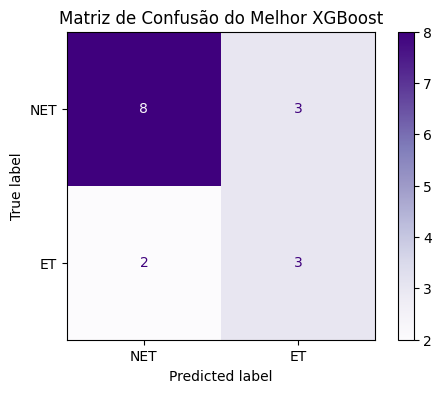


--- 4. Análise de Importância das Features ---
                Feature  Importance
7         has_citations    0.400955
3    npl_citation_count    0.176780
0                  ctsi    0.090244
2    cites_patent_count    0.083998
6        inventor_count    0.077502
4  extended_family_size    0.061547
5                   tct    0.058310
1                  casi    0.050664

--- 5. Calculando a Curva ROC e o AUROC ---
Área sob a Curva ROC (AUROC): 0.64


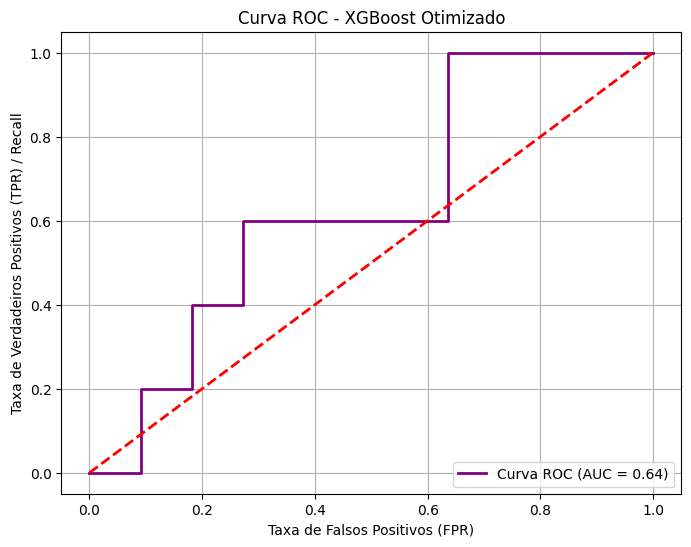

In [ ]:

print("1. Preparando os Dados")

# a. Separar features (X) e o alvo (y)
features = ['ctsi', 'casi','cites_patent_count', 'npl_citation_count', 'extended_family_size', 'tct', 'inventor_count', 'has_citations']
X = cluster_feature_vector_labeled[features]
y = cluster_feature_vector_labeled['label'].map({'ET': 1, 'NET': 0})

print("Rótulos convertidos para formato numérico (ET=1, NET=0).")

# b. Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Dados divididos em {len(X_train)} amostras de treino e {len(X_test)} de teste.")

# c. Normalizar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Features de treino e teste foram normalizadas.\n")

# d. Calcular o peso para a classe positiva (para o XGBoost)
# scale_pos_weight = contagem_negativos / contagem_positivos
count_neg = np.sum(y_train == 0)
count_pos = np.sum(y_train == 1)
scale_pos_weight_value = count_neg / count_pos if count_pos > 0 else 1
print(f"Calculado 'scale_pos_weight' para o XGBoost: {scale_pos_weight_value:.2f}\n")


print("Buscando e Treinando o Melhor Modelo XGBoost")

# Define a grade de parâmetros para testar no XGBoost
param_grid = {
    'n_estimators': [100, 200],             # Número de árvores
    'max_depth': [3, 5, 7],                 # Profundidade máxima
    'learning_rate': [0.05, 0.1],           # Taxa de aprendizado
    'subsample': [0.7, 1.0],                # Fração de amostras por árvore
    'colsample_bytree': [0.7, 1.0]          # Fração de features por árvore
}

# Cria o objeto GridSearchCV para o XGBoost
# O 'scale_pos_weight' é passado diretamente para o classificador
grid = GridSearchCV(
    xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight_value),
    param_grid,
    refit=True,
    verbose=2,
    scoring='f1',
    cv=5
)

# Treina o GridSearchCV
grid.fit(X_train_scaled, y_train)

print(f"\nMelhores parâmetros encontrados: {grid.best_params_}")
best_model = grid.best_estimator_
print("Melhor modelo XGBoost treinado com sucesso!\n")


# --- 3. Avaliação do Desempenho do MELHOR Modelo ---
print("--- 3. Avaliando o Desempenho do MELHOR Modelo ---")

y_pred = best_model.predict(X_test_scaled)

print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['NET (0)', 'ET (1)'], zero_division=0))

print("Matriz de Confusão:")
fig, ax = plt.subplots(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['NET', 'ET'], cmap='Purples', ax=ax)
ax.set_title("Matriz de Confusão do Melhor XGBoost")
plt.show()

print("\n--- 4. Análise de Importância das Features ---")
importances = best_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print(feature_importance_df)

print("\n--- 5. Calculando a Curva ROC e o AUROC ---")

y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"Área sob a Curva ROC (AUROC): {auc_score:.2f}")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'Curva ROC (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR) / Recall')
plt.title('Curva ROC - XGBoost Otimizado')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
# RASCUNHO ----- DESCONSIDERAR #

filtered_br_df_RASCUNHO = pd.read_pickle("/content/drive/MyDrive/rp_data/patentes_com_tct.pkl")
pd.set_option('display.max_columns', None)
display(filtered_br_df_RASCUNHO.head())

,#,Jurisdiction,Kind,Display Key,Lens ID,Publication Date,Publication Year,Application Number,Application Date,Priority Numbers,Earliest Priority Date,Title,Abstract,Applicants,Inventors,Owners,URL,Document Type,Has Full Text,Cites Patent Count,Cited by Patent Count,Simple Family Size,Simple Family Members,Simple Family Member Jurisdictions,Extended Family Size,Extended Family Members,Extended Family Member Jurisdictions,Sequence Count,CPC Classifications,IPCR Classifications,US Classifications,NPL Citation Count,NPL Resolved Citation Count,NPL Resolved Lens ID(s),NPL Resolved External ID(s),NPL Citations,Legal Status,Extracted ISSNs,Cited_Data,TCT
0,1,WO,A1,WO 2025/184719 A1,124-441-664-420-789,2025-09-12,2025,BR BR2025/050088,2025-03-07,BR 1020240045750,2024-03-07,PHARMACEUTICAL COMPOSITION COMPRISING PLANT EX...,The present invention relates to a pharmaceuti...,"JOSEPH HUBER, Konrad;;DAHER HUBER, Patricia",NaN,NaN,https://lens.org/124-441-664-420-789,Patent Application,yes,0,0,1,124-441-664-420-789,WO,1,124-441-664-420-789,WO,0,NaN,A61K36/18;;A61K36/23;;A61K36/484;;A61P31/22,NaN,0,0,NaN,NaN,NaN,UNKNOWN,NaN,[],0.0
1,2,US,A1,US 2025/0282832 A1,181-825-211-788-302,2025-09-11,2025,US 18553324,2022-03-30,BR 10 2021 006 401-3,2021-04-01,"CHIMERIC NUCLEOTIDE SEQUENCE, VECTOR FOR EXPRE...",A chimeric nucleotide sequence that correspond...,IMUNOTERA SOLUÇÕES TERAPÊUTICAS LTDA.,Rúbens Prince Dos Santos ALVES;;Luana Raposo D...,NaN,https://lens.org/181-825-211-788-302,Patent Application,yes,0,0,1,181-825-211-788-302,US,1,181-825-211-788-302,US,0,C07K14/005;;A61P31/14;;C12N15/85;;A61K2039/53;...,C07K14/005;;A61K39/00;;A61P31/14;;C12N15/85,NaN,0,0,NaN,NaN,NaN,UNKNOWN,NaN,[],0.0
2,3,EP,A1,EP 4613259 A1,111-161-383-779-770,2025-09-10,2025,EP 23883923 A,2023-10-30,BR 102022022130 A;;BR 2023050367 W,2022-10-31,"PHARMACEUTICAL, DERMATOLOGICAL OR COSMETIC COM...",The present invention describes new compounds ...,CHEMYUNION LTDA,KATEKAWA EDSON;;ROGERIO PRINCIVAL CLEVERSON;;M...,NaN,https://lens.org/111-161-383-779-770,Patent Application,yes,0,0,2,111-161-383-779-770;;169-556-118-004-73X,EP;;WO,2,111-161-383-779-770;;169-556-118-004-73X,EP;;WO,0,A61Q19/02;;A61K8/64,A61K8/64;;A61Q19/02,NaN,0,0,NaN,NaN,NaN,PENDING,NaN,[],0.0
3,4,EP,A4,EP 4397299 A4,094-894-006-498-344,2025-09-10,2025,EP 22862452 A,2022-09-01,BR 102021017465 A;;BR 2022050348 W,2021-09-02,METHOD FOR PRODUCING PRESERVED COLLAGENOUS CON...,NaN,LABCOR LABORATORIOS LTDA,JOVIANO CASAGRANDE IVAN SÉRGIO;;PADILHA JUNQUE...,LABCOR LABORATORIOS LTDA. (2024-10-02),https://lens.org/094-894-006-498-344,Search Report,no,0,0,6,080-820-749-740-701;;094-894-006-498-344;;123-...,JP;;EP;;WO;;US;;BR,7,134-609-196-286-409;;100-704-568-122-520;;080-...,JP;;EP;;WO;;US;;BR,0,A61L27/3604;;A61L27/3687;;A61L27/3645;;A61L243...,A61K8/65;;A61K8/72;;A61K8/98,NaN,0,0,NaN,NaN,NaN,PENDING,NaN,[],0.0
4,5,EP,A1,EP 4613260 A1,034-338-369-366-988,2025-09-10,2025,EP 23883925 A,2023-10-31,BR 102022022131 A;;BR 2023050369 W,2022-10-31,"COMPOUNDS AND COSMETIC, DERMOCOSMETIC, COSMECE...",The present invention describes new compounds ...,CHEMYUNION LTDA,KATEKAWA EDSON;;ROGERIO PRINCIVAL CLEVERSON;;M...,NaN,https://lens.org/034-338-369-366-988,Patent Application,yes,0,0,2,034-338-369-366-988;;183-191-760-515-05X,EP;;WO,2,034-338-369-366-988;;183-191-760-515-05X,EP;;WO,0,A61K8/64;;A61Q19/08,A61K8/64;;A61Q19/08,NaN,0,0,NaN,NaN,NaN,PENDING,NaN,[],0.0
